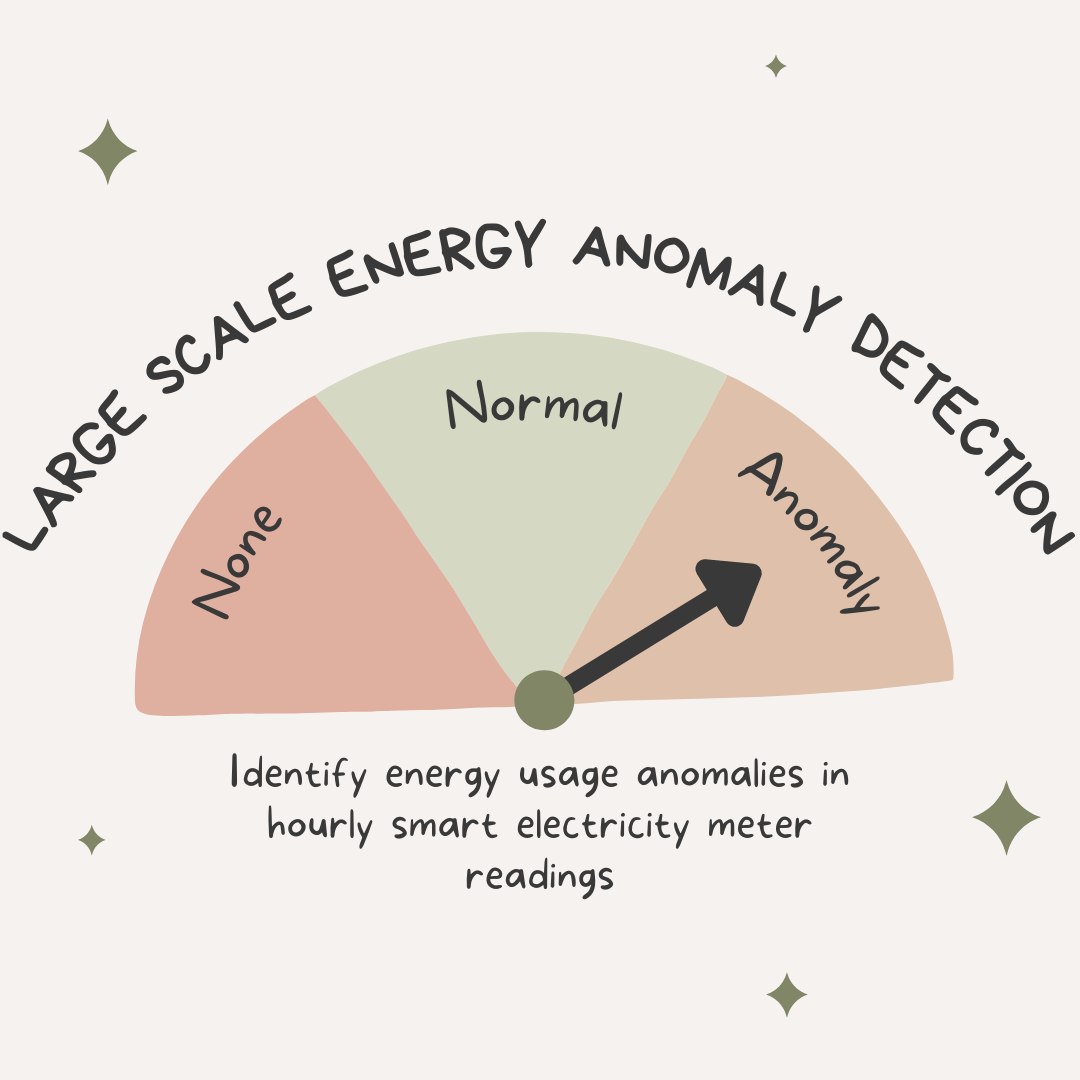

# <p style="text-align:center;font-size:150%;font-family:Roboto;background-color:#a04070;border-radius:50px;font-weight:bold;margin-bottom:0">Large Scale Energy Anomaly Detection</p>

<p style="font-family:Roboto;font-size:140%;color:#a04070;">In this Notebook, I had implemented the anomaly detection model to predict whether the energy usage in a building is anomalous or not. Significance of this project lies in the fact that the anomalous usage implies energy wastage and we can prevent this by identifying such instances. This will help to save a lot of energy. In this notebook I had just used the <code>train.csv</code> data to build a model.<p> 

<!-- <a id='top'></a> -->
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#a04070;font-family:Roboto;font-size:160%;text-align:center;border-radius:50px;">TABLE OF CONTENTS</p>   
    
* [1. Importing Libraries](#1)
    
* [2. Exploratory Data Analysis and Feature Extraction](#2)
    
* [3. Equalizing Data and Preprocessing](#3)
    
* [4. Model Development and Predictions](#4) 
    
* [5. The End](#5) 

<a id="1"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">IMPORTING LIBRARIES</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm, trange
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

<a id="2"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">Exploratory Data Analysis and Feature Extraction</p>
<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">By using the timestamp we will develop some features and side by side make some visualization to predict the relation ship between different variables.</p>

In [2]:
train = pd.read_csv('../input/energy-anomaly-detection/train.csv')
train.head()

,building_id,timestamp,meter_reading,anomaly
0,1,2016-01-01 00:00:00,NaN,0
1,32,2016-01-01 00:00:00,NaN,0
2,41,2016-01-01 00:00:00,NaN,0
3,55,2016-01-01 00:00:00,NaN,0
4,69,2016-01-01 00:00:00,NaN,0


<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Clearly there are null values in the <code>meter_reading</code> column.</p>

In [3]:
train.shape

(1749494, 4)

In [4]:
train.isnull().sum()

building_id           0
timestamp             0
meter_reading    107653
anomaly               0
dtype: int64

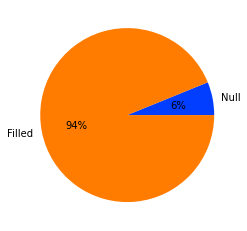

In [5]:
k = train.isnull().sum().sum()
plt.pie([k, train.shape[0]-k], labels=['Null', 'Filled']\
        , colors=sb.color_palette('bright'), autopct='%.0f%%')
plt.show()


<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">So, around <code>6%</code> of the total entry's have null value in the meter_reading column.</p>

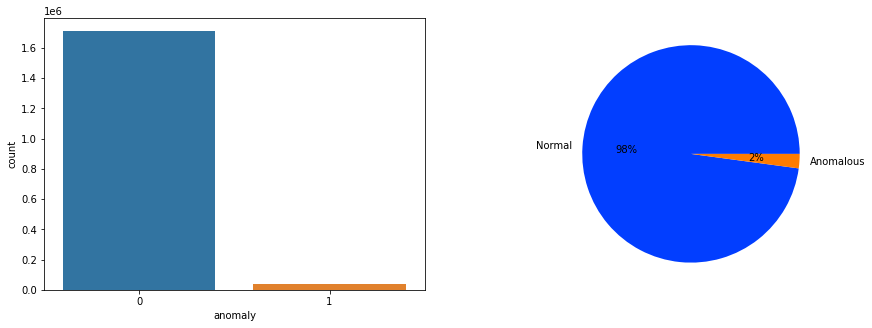

In [6]:
plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
sb.countplot(x=train['anomaly'])
plt.subplot(1,2,2)
data = train['anomaly'].value_counts()
plt.pie(data, labels=['Normal', 'Anomalous'], colors=sb.color_palette('bright'), autopct='%.0f%%')
plt.show()

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">As expected generally in a anomaly detection problem data imbalance is an obvious case because anomalies as rare cases which do not occur oftenly else there must be some other default.</p>

In [7]:
mean_reading = train.groupby('building_id').mean()['meter_reading']

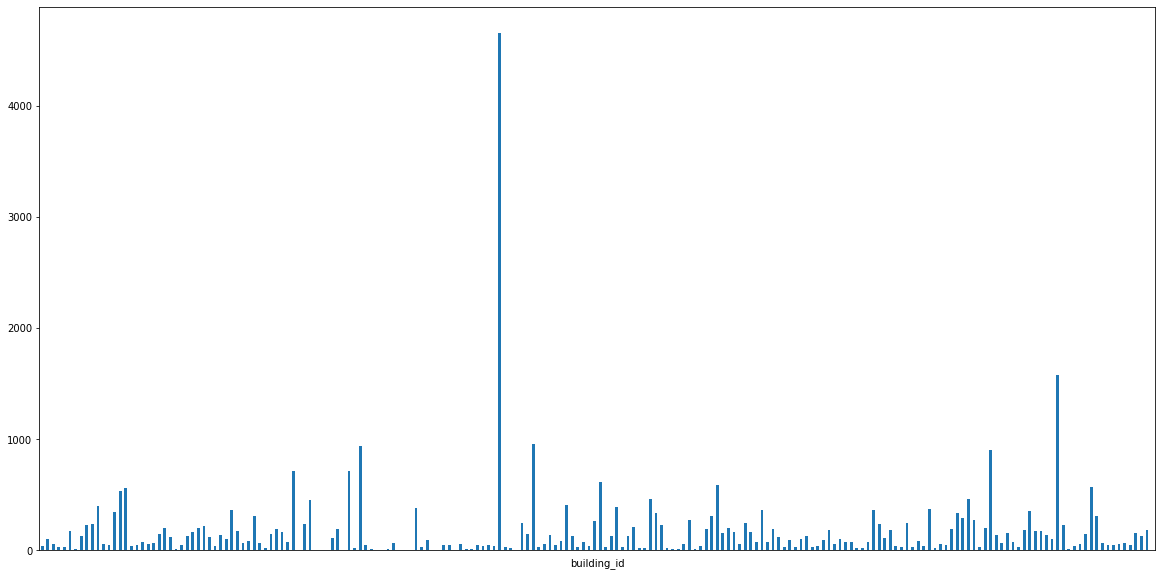

In [8]:
plt.figure(figsize=(20,10))
mean_reading.plot.bar()
plt.xticks([])
plt.show()

In [9]:
mean_reading.idxmax()

801

<ul style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0"><li>The building with id equal to <code>801</code> has mean <code>meter_reading</code> too high as compare to other buildings seems like a skyscrapper to me😆 and some buildings seems to have very low mean <code>meter_reading</code>.</li><li>

This mean statistics is for throughout the year. We will see further in this notebook is there some variation in the mean usage during different days/month.</li></ul>

In [10]:
def add_date_time(data):
  new = data['timestamp'].str.split(' ', n = 1, expand=True)
  data['date'] = new[0]
  data['time'] = new[1]
  data['time'] = data['time'].str[:2].astype(int)
  data = data.drop(['timestamp'], axis=1)

  return data

train = add_date_time(train)
train.head()

,building_id,meter_reading,anomaly,date,time
0,1,NaN,0,2016-01-01,0
1,32,NaN,0,2016-01-01,0
2,41,NaN,0,2016-01-01,0
3,55,NaN,0,2016-01-01,0
4,69,NaN,0,2016-01-01,0


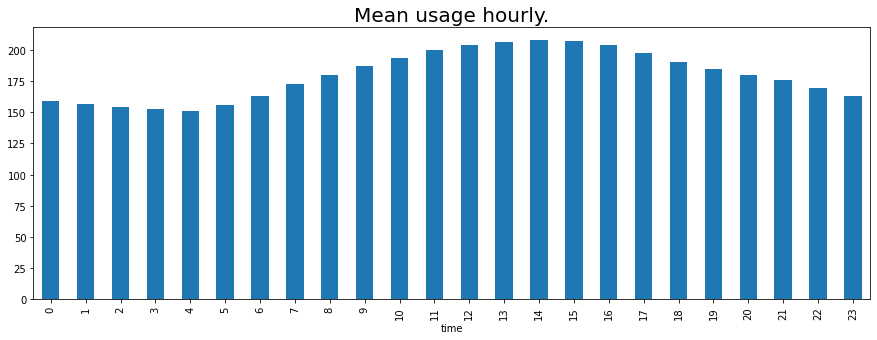

In [11]:
plt.figure(figsize=(15,5))
train.groupby('time').mean()['meter_reading'].plot.bar()
plt.title('Mean usage hourly.', fontsize=20)
plt.show()

In [12]:
def add_month_day(data):
  data['month'] = data['date'].str[5:7].astype(int)
  data['day'] = data['date'].str[-2:].astype(int)
  data = data.drop(['date'], axis=1)

  return data

train = add_month_day(train)
train.head()

,building_id,meter_reading,anomaly,time,month,day
0,1,NaN,0,0,1,1
1,32,NaN,0,0,1,1
2,41,NaN,0,0,1,1
3,55,NaN,0,0,1,1
4,69,NaN,0,0,1,1


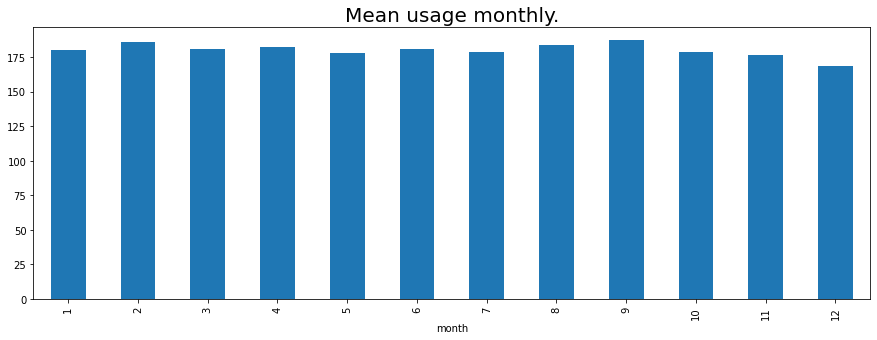

In [13]:
plt.figure(figsize=(15,5))
train.groupby('month').mean()['meter_reading'].plot.bar()
plt.title('Mean usage monthly.', fontsize=20)
plt.show()

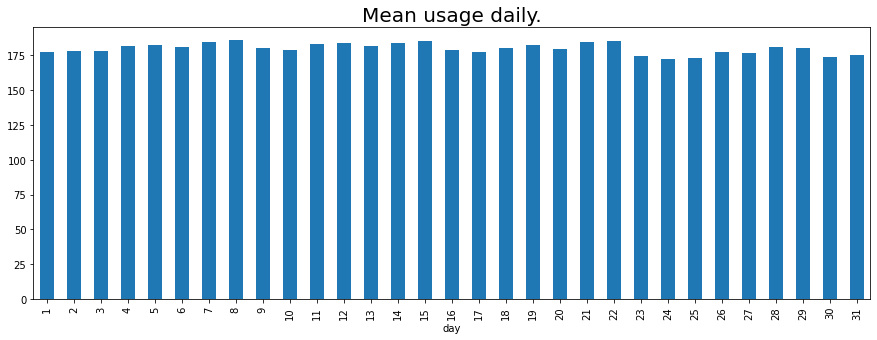

In [14]:
plt.figure(figsize=(15,5))
train.groupby('day').mean()['meter_reading'].plot.bar()
plt.title('Mean usage daily.', fontsize=20)
plt.show()

In [15]:
train.head()

,building_id,meter_reading,anomaly,time,month,day
0,1,NaN,0,0,1,1
1,32,NaN,0,0,1,1
2,41,NaN,0,0,1,1
3,55,NaN,0,0,1,1
4,69,NaN,0,0,1,1


In [16]:
# Feature denoting whether it was a weekday or weekend.
def weekend_or_weekday(year,month,day):
    
    d = datetime(year,month,day)
    if d.weekday()>4:
        return 1
    else:
        return 0


train['weekend'] = train.apply(lambda x:\
                               weekend_or_weekday(int(2016),int(x['month']),int(x['day'])),axis=1)
train.head()

,building_id,meter_reading,anomaly,time,month,day,weekend
0,1,NaN,0,0,1,1,0
1,32,NaN,0,0,1,1,0
2,41,NaN,0,0,1,1,0
3,55,NaN,0,0,1,1,0
4,69,NaN,0,0,1,1,0


In [17]:
train['weekend'].value_counts()

0    1247563
1     501931
Name: weekend, dtype: int64

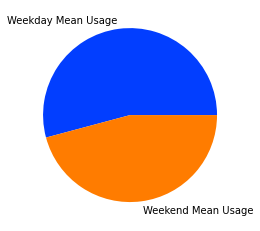

In [18]:
data = train.groupby('weekend')['meter_reading'].mean()
plt.pie(data, labels=['Weekday Mean Usage', 'Weekend Mean Usage']\
        , colors=sb.color_palette('bright'))
plt.show()

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">This means that the mean power usage of th buildings are higher during weekdays than the weekends which seems like obvious because offices, schools, colleges remains shut on the weekends.</p>

In [19]:
def impute_nulls(data):
    mean_reading = data.groupby('building_id').mean()['meter_reading']
    building_id = mean_reading.index
    values = mean_reading.values
    
    for i, idx in enumerate(building_id):
        data[data['building_id']==idx] = data[data['building_id']==idx].fillna(values[i]) 
    
    return data

train = impute_nulls(train)

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Although from the above charts we can observe that the mean usage of all the building is approximately same throughout the year (monthly, daily) and is around <code>175 kwh</code> approx. but we cannot impute the missing values with this as some buildings have very high usage stats and some buildings have readings even close to zero.</p>

<a id="3"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">Equalizing Data and Preprocessing</p>
<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">As there is a high imbalance in the data so, if we won't equalize the positive and the negative examples in the data then the model will have a hard time generalizing the positive examples which is the main goal here. </p>

In [20]:
neg = train[train['anomaly'] == 0]
pos = train[train['anomaly'] == 1]

print(neg.shape, pos.shape)
negs1 = neg.sample(n = 37296, random_state=10)
negs2 = neg.sample(n = 37296, random_state=20)
df_eq = pd.concat([negs1, pos, negs2, pos], axis=0)
print(df_eq.shape)

(1712198, 7) (37296, 7)
(149184, 7)


<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Yes, by using this method our model won't be able to see all the data even once but this will helps the model to generalize well on the positive as well as negative examples.</p>

In [21]:
features = df_eq.drop(['building_id', 'anomaly'], axis=1)
target = df_eq['anomaly']

In [22]:
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size = 0.01, random_state=10)
print(X_train.shape, X_val.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

(147692, 5) (1492, 5)


<a id="4"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">Model Development and Predictions</p>
<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Training data is ready now so, let us use some state of the art model to get a baseline on which we can build up by using the features data. Same set of processing needs to be done in the same order as we did in the training data so, that we don't do any mistake.</p>

In [23]:
models = [LogisticRegression(), XGBClassifier()]

for i in range(2):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_val, models[i].predict_proba(X_val)[:,1]))
    print()

LogisticRegression() : 
Training Accuracy :  0.5695351545651138
Validation Accuracy :  0.5605979721289052

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) : 
Training Accuracy :  0.9546005366054557
Validation Accuracy :  0.949269071281053



<ul style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0"><li>Logistic regressions accuracy is too low but <code>XGBClassifier</code> is performing really well without any overfitting it give <code>94%</code> validation accuracy.</li><li>
At this point you may have one doubt in your mind that why I am predicting probabilities instead of binary predictions then please pay a visit to this <a href='https://www.kaggle.com/competitions/autismdiagnosis/discussion/324427', target='_blank'>discussion</a> do let me know your thoughts about it.</li></ul>

In [24]:
test = pd.read_csv('../input/energy-anomaly-detection/test.csv', index_col=0)
test = add_date_time(test)
test = add_month_day(test)
test['weekend'] = test.apply(lambda x:\
                               weekend_or_weekday(int(2016),int(x['month']),int(x['day'])),axis=1)
test.head()

,building_id,meter_reading,time,month,day,weekend
row_id,,,,,,
0,18,NaN,0,1,1,0
1,19,NaN,0,1,1,0
2,26,NaN,0,1,1,0
3,38,NaN,0,1,1,0
4,39,NaN,0,1,1,0


In [25]:
test.shape

(1800567, 6)

In [26]:
test.isnull().sum()

building_id          0
meter_reading    94864
time                 0
month                0
day                  0
weekend              0
dtype: int64

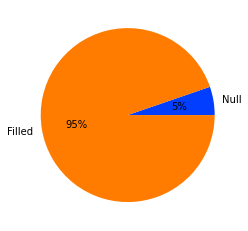

In [27]:
k = test.isnull().sum().sum()
plt.pie([k, test.shape[0]-k], labels=['Null', 'Filled']\
        , colors=sb.color_palette('bright'), autopct='%.0f%%')
plt.show()

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">So, <code>5%</code> of the entries in the meter_reading of the test data is null which is similar to the train data which has approximately <code>6%</code> of the <code>meter_reading</code> as null.</p>

In [28]:
test = impute_nulls(test)
test.isnull().sum().sum()

0

In [29]:
test = test.drop(['building_id'], axis=1)
test = scaler.transform(test)

In [30]:
predictions = models[1].predict_proba(test)[:,1]

In [31]:
ss = pd.read_csv('../input/energy-anomaly-detection/sample_submission.csv')
ss['anomaly'] = predictions
ss.to_csv('Submission.csv', index=False)
ss.head()

,row_id,anomaly
0,0,0.194004
1,1,0.478195
2,2,0.571356
3,3,0.307054
4,4,0.211086


<a id="5"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">The End</p>
<ul style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0"> <li>Score evaluaton using the binary prediction and probability prediction gives different scores on the same set of predictions do visit the above discussion to know why this happens.</li><li>I am working on another notebook as well in which I will develop a model by using the <code>train_features.csv</code> data to get better results.</li> </ul>